# Load library

In [9]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import my_utils as mu
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torchvision # used to load data
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

# Load Data and transform data

In [12]:
# Data augmentation used to reduce overfitting and increase accuracy
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    #transforms.Resize((224, 224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #Normalise data
])

transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Resize((224, 224)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Normalise data

# Loading training and testing set
batch_size = 32
trainset = torchvision.datasets.CIFAR10(root='./data/', train=True, download=True, transform=transform_train) # 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


# Visualise Inputs

In [15]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

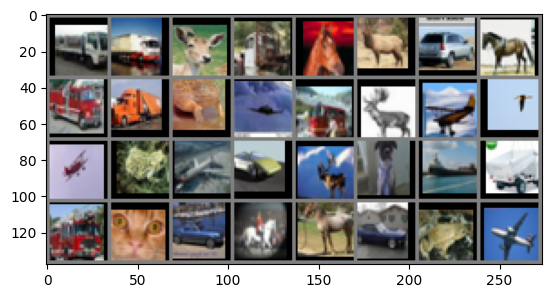

truck truck deer  truck horse deer  car   horse truck truck frog  plane truck deer  plane bird  plane frog  plane car   deer  dog   ship  truck truck cat   car   horse horse car   frog  plane


In [17]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# VGG 16 Model

In [20]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs):
        super(VGGBlock, self).__init__()
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            in_channels = out_channels
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            VGGBlock(3, 64, 2),       # Block 1
            VGGBlock(64, 128, 2),     # Block 2
            VGGBlock(128, 256, 3),    # Block 3
            VGGBlock(256, 512, 3),    # Block 4
            VGGBlock(512, 512, 3)     # Block 5
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 4096),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)      
        x = self.classifier(x)    
        return x

# Load model, loss and optimiser

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
net = VGG16()
net.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Model Summary

In [26]:
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
          VGGBlock-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

# Train model and visualise training and testing

In [29]:
def trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device, writer):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = mu.d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = mu.d2l.Timer()
    epoch_data = []
    writer.add_text('Hyperparameters', f'Learning Rate: {optimizer.param_groups[0]["lr"]}', 0)
    for epoch in range(num_epochs):
        metric = mu.d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], mu.d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                              (train_loss, train_acc, None))
                
        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_acc, epoch)
            
        test_acc = mu.evaluate_accuracy_gpu(net, test_iter, device)
        animator.add(epoch+1, (None, None, test_acc))
        writer.add_scalar('Test/Accuracy', test_acc, epoch)
        
        # Collect epoch data
        epoch_data.append({
            'epoch': epoch + 1,
            'loss': train_loss,
            'train_acc': train_acc,
            'test_acc': test_acc
        })
        
    # After all epochs, print the collected data
    print("-------------------------------------------------------")
    for data in epoch_data:
        print(f"Epoch {data['epoch']}, Loss: {data['loss']:.3f}, "
              f"Train Acc: {data['train_acc']:.3f}, Test Acc: {data['test_acc']:.3f}")
        
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(device)}')

    
    writer.close()


-------------------------------------------------------
Epoch 1, Loss: 1.487, Train Acc: 0.458, Test Acc: 0.607
Epoch 2, Loss: 0.960, Train Acc: 0.661, Test Acc: 0.713
Epoch 3, Loss: 0.763, Train Acc: 0.738, Test Acc: 0.748
Epoch 4, Loss: 0.658, Train Acc: 0.775, Test Acc: 0.798
Epoch 5, Loss: 0.582, Train Acc: 0.802, Test Acc: 0.811
Epoch 6, Loss: 0.528, Train Acc: 0.821, Test Acc: 0.829
Epoch 7, Loss: 0.480, Train Acc: 0.837, Test Acc: 0.834
Epoch 8, Loss: 0.440, Train Acc: 0.848, Test Acc: 0.843
Epoch 9, Loss: 0.408, Train Acc: 0.860, Test Acc: 0.860
Epoch 10, Loss: 0.387, Train Acc: 0.868, Test Acc: 0.848
Epoch 11, Loss: 0.355, Train Acc: 0.879, Test Acc: 0.869
Epoch 12, Loss: 0.333, Train Acc: 0.886, Test Acc: 0.866
Epoch 13, Loss: 0.315, Train Acc: 0.893, Test Acc: 0.869
Epoch 14, Loss: 0.295, Train Acc: 0.898, Test Acc: 0.871
Epoch 15, Loss: 0.285, Train Acc: 0.902, Test Acc: 0.882
Epoch 16, Loss: 0.268, Train Acc: 0.908, Test Acc: 0.877
Epoch 17, Loss: 0.252, Train Acc: 0.914, 

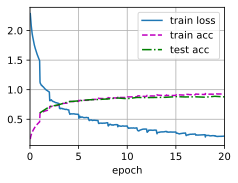

In [31]:
writer = SummaryWriter('runs/VGG16_CIFAR10')

num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
trainf(net, trainloader, testloader, loss, num_epochs, optimizer, device, writer)

In [32]:
torch.cuda.empty_cache()

# Visualise Test set predictions

In [34]:
def visualize_random_predictions(net, data_iter, device, num_images=10):
    classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    net.eval()  
    images, labels = next(iter(data_iter))  
    
    # Randomly select image indices
    indices = np.random.choice(len(images), num_images, replace=False)
    
    images_selected = images[indices].to(device)
    labels_selected = labels[indices]
    
    with torch.no_grad():
        pred_probs = net(images_selected)
        pred_labels = torch.argmax(pred_probs, axis=1)
    
    images_selected = images_selected.cpu()
    pred_labels = pred_labels.cpu()
    
    # Plotting
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))  
    for i, ax in enumerate(axs.flat):
        img = images_selected[i] / 2 + 0.5
        ax.imshow(np.transpose(img, (1, 2, 0))) 
        true_label = classes[labels_selected[i]]
        pred_label = classes[pred_labels[i]]
        ax.set_title(f'Pred: {pred_label}, True: {true_label}')
        ax.axis('off')
    
    plt.show()


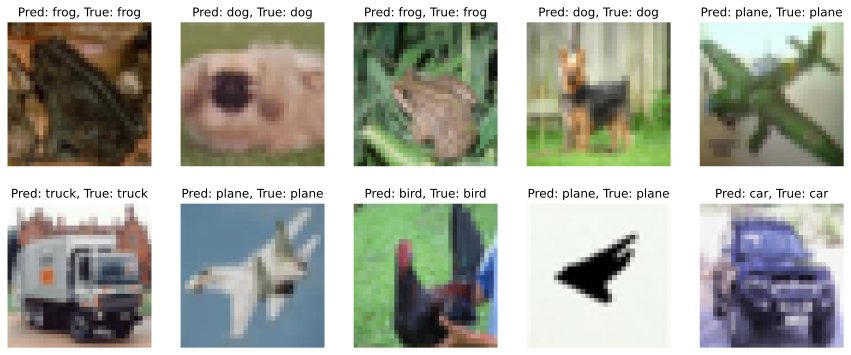

In [35]:
visualize_random_predictions(net, testloader, device)